In [30]:
import kagglehub

path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-ctscan-images


In [31]:
from pathlib import Path

In [32]:
base_path = Path("/kaggle/input/chest-ctscan-images/Data")

train_path = base_path / "train"
val_path   = base_path / "valid"
test_path  = base_path / "test"


In [33]:
print (train_path)

/kaggle/input/chest-ctscan-images/Data/train


In [34]:
!ls /kaggle/input/chest-ctscan-images/Data

test  train  valid


In [35]:
import cv2 as cv
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D

from matplotlib.image import imread
import matplotlib.pyplot as plt
import random

from resnet50 import ResNet50

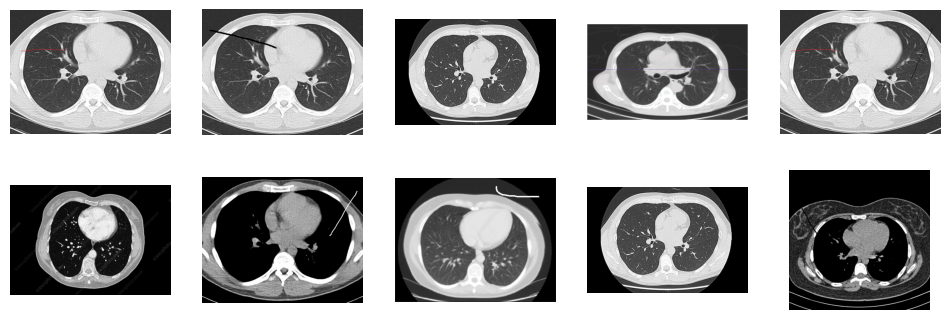

In [36]:
def visualize_images(folder_path):
    image_files = os.listdir(folder_path)
    fig, ax = plt.subplots(2,5, figsize=(12,4))

    for i in range(2):
        for j in range(5):
            img_path = os.path.join(folder_path, random.choice(image_files))
            image = imread(img_path)
            ax[i, j].imshow(image, cmap="gray")
            ax[i, j].axis('off')

    plt.show()

folder_path = os.path.join(train_path, 'normal')
visualize_images(folder_path)

In [37]:
#image augmentation
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range= 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   preprocessing_function=preprocess_input,
                                   dtype="float32")

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

In [38]:
train_data = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode="categorical")
val_data = val_datagen.flow_from_directory(val_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode="categorical")

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [39]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [40]:
resnet = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
resnet.summary()

94653016/94653016 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ batch_normalizat

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [41]:
for layer in resnet.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,128,452 (164.52 MB)

 Trainable params: 19,536,644 (74.53 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [42]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
#training
mc1 = ModelCheckpoint(
    filepath="ct_resnet_best_model.keras",
    monitor="val_accuracy",
    save_best_only="True",
    mode = 'max',)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights = True)
#Defining LR Reducing rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 5,
                             verbose = 1,
                             min_delta = 0.8)

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs = 50,
                    batch_size=32,
                    callbacks=[mc1, early_stopping]
                   )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3884 - loss: 4.4129 - val_accuracy: 0.4861 - val_loss: 5.2028
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 672ms/step - accuracy: 0.4935 - loss: 2.9654 - val_accuracy: 0.5278 - val_loss: 0.9709
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 702ms/step - accuracy: 0.5277 - loss: 1.9035 - val_accuracy: 0.5417 - val_loss: 1.0727
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 556ms/step - accuracy: 0.5722 - loss: 1.2767 - val_accuracy: 0.5000 - val_loss: 1.1757
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 668ms/step - accuracy: 0.5763 - loss: 1.1557 - val_accuracy: 0.6111 - val_loss: 0.7661
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 555ms/step - accuracy: 0.5516 - loss: 1.0266 - val_accuracy: 0.5139 - val_loss: 0.9561
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 675ms/step - accuracy: 0.6004 - loss: 1.0196 - val_accuracy: 0.6944 - val_loss: 0.7186
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 560ms/step - accuracy: 0.6071 - loss: 0.8637 - val_accurac

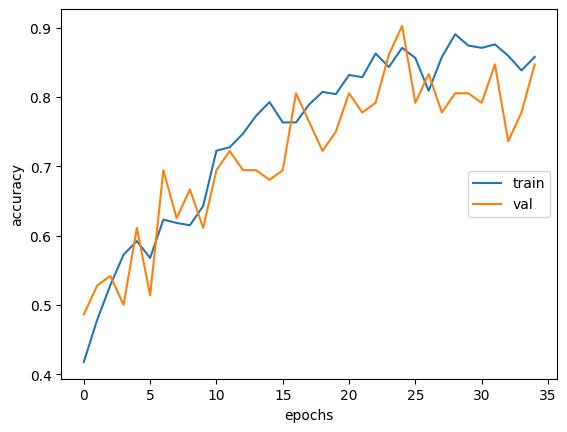

In [44]:
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val")
plt.legend(loc="right")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [45]:
saved_model = load_model("ct_resnet_best_model.keras")

In [46]:
score = saved_model.evaluate(test_data, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 858ms/step - accuracy: 0.7603 - loss: 0.5742
Test loss: 0.5816907286643982
Test accuracy: 0.7587301731109619
